### $\hat{y}=WX+b$
- $W$ n维的权重
- $X$ n个影响因子
- $b$ 标量偏差
### $Loss$
- $Loss=\frac{1}{2}(\hat{y}-y)^2$

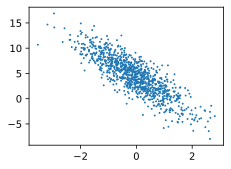

In [1]:
%matplotlib inline
import d2l
import torch
from d2l import torch as d2l
def synthetic_data(w,b,examNum):
    x = torch.normal(0,1,(examNum,len(w)))
    y = torch.matmul(x,w)+b
    y += torch.normal(0,0.01,y.shape)
    return x,y.reshape((-1,1))

tw = torch.tensor([2,-3.4])
tb = 4.2
x_data,y_data = synthetic_data(tw,tb,1000)
d2l.set_figsize()
d2l.plt.scatter(x_data[:,1].detach().numpy(),y_data.detach().numpy(),1)


In [2]:
def data_iter(batch_size, x_data, y_data):
    num_examples = len(x_data)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    d2l.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield x_data[batch_indices], y_data[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, x_data, y_data):
    print(X, '\n', y)
    break

tensor([[-0.0137, -0.0636],
        [-0.6598,  0.4078],
        [-0.0542, -0.1511],
        [ 1.7524,  0.1044],
        [-0.8554,  0.2807],
        [ 1.1991,  0.4568],
        [ 1.2160,  0.3013],
        [-0.0272, -0.0773],
        [ 1.7492, -0.0395],
        [-0.3285,  0.9431]]) 
 tensor([[4.3694],
        [1.4936],
        [4.6201],
        [7.3570],
        [1.5247],
        [5.0448],
        [5.6203],
        [4.4037],
        [7.8379],
        [0.3351]])


In [3]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [4]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [5]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, x_data, y_data):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(x_data, w, b), y_data)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031868
epoch 2, loss 0.000117
epoch 3, loss 0.000052


In [6]:
print(f'w的估计误差: {tw - w.reshape(tw.shape)}')
print(f'b的估计误差: {tb - b}')

w的估计误差: tensor([ 0.0008, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


In [7]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

epoch 1, loss 0.000239
epoch 2, loss 0.000102
epoch 3, loss 0.000104
w的估计误差： tensor([-0.0008, -0.0010])
b的估计误差： tensor([0.0006])
